In [1]:
import os
import glob
from pyspark.sql import SparkSession

# Caminho da pasta de saída
output_folder = "../Scripts/output"

# Obter lista de arquivos CSV de blocos
block_files = glob.glob(os.path.join(output_folder, "block", "*.csv"))

# Obter lista de arquivos CSV de swaps
swap_files = glob.glob(os.path.join(output_folder, "swap", "*.csv"))

# Obter lista de arquivos CSV de transações
transaction_files = glob.glob(os.path.join(output_folder, "transaction", "*.csv"))

In [2]:
# Criar sessão Spark
spark = SparkSession.builder \
    .appName("Análise de Transações Ethereum") \
    .getOrCreate()

In [3]:
# Criar um DataFrame vazio para armazenar os dados dos blocos
combined_block_df = None

# Ler e unir os arquivos CSV de blocos
for file in block_files:
    df = spark.read.csv(file, header=True, inferSchema=True)
    if combined_block_df is None:
        combined_block_df = df
    else:
        combined_block_df = combined_block_df.unionAll(df)

In [4]:
combined_block_df.show()

+--------+--------------------+--------------------+----------+--------------------+------+---------+--------+---------------+-----------------+
|Block_ID|          Hash_Bloco|               Miner|Difficulty|    Total_Difficulty|  Size|Gas_Limit|Gas_Used|Timestamp_Bloco|Numero_Transacoes|
+--------+--------------------+--------------------+----------+--------------------+------+---------+--------+---------------+-----------------+
|17612313|0xb1c14c701b0b6ca...|0x95222290DD7278A...|         0|58750003716598352...| 50751| 30000000|13316124|     1688373611|              169|
|17612314|0x7cf64d96112f8fa...|0x1f9090aaE28b8a3...|         0|58750003716598352...|299493| 30000000|17521385|     1688373623|              165|
|17612315|0xd688e4beaa28c74...|0xDAFEA492D9c6733...|         0|58750003716598352...|265609| 30000000|15773074|     1688373635|              143|
|17612316|0xce182e813d41c01...|0x690B9A9E9aa1C9d...|         0|58750003716598352...| 66694| 30000000|15149283|     1688373647|    

In [5]:
# Criar um DataFrame vazio para armazenar os dados dos blocos
combined_swap_df = None

# Ler e unir os arquivos CSV de blocos
for file in swap_files:
    df = spark.read.csv(file, header=True, inferSchema=True)
    if combined_swap_df is None:
        combined_swap_df = df
    else:
        combined_swap_df = combined_swap_df.unionAll(df)

In [6]:
combined_swap_df.show()

+--------+--------------------+------------------+------------------+--------------------+--------------------+--------------------+---------------+-------------+---------------------+-------------------+-------------------+------------------+--------------------+
|Block_ID|    type_Transaction|      amountOutMin|         amountOut|            amountIn|    fromTokenAddress|      toTokenAddress|fromTokenSymbol|toTokenSymbol|fromTokenHoldersCount|toTokenHoldersCount|     fromTokenPrice|      toTokenPrice|     hashTransaction|
+--------+--------------------+------------------+------------------+--------------------+--------------------+--------------------+---------------+-------------+---------------------+-------------------+-------------------+------------------+--------------------+
|17612313|swapExactTokensFo...| 19293763248568350| 38206619727643455|    3584893950000000|0x5e4195488BBA6af...|0xC02aaA39b223FE8...|        PEPEGOD|         WETH|                  121|             806476| 

In [7]:
# Criar um DataFrame vazio para armazenar os dados dos blocos
combined_transaction_df = None

# Ler e unir os arquivos CSV de blocos
for file in transaction_files:
    df = spark.read.csv(file, header=True, inferSchema=True)
    if combined_transaction_df is None:
        combined_transaction_df = df
    else:
        combined_transaction_df = combined_transaction_df.unionAll(df)

In [8]:
combined_transaction_df.show()

+--------+--------------------+--------------------+--------------------+-------------------+------------+----------+----------+-------------------+
|Block_ID|      Hash_Transacao|           Remetente|        Destinatario|        Valor_(Wei)|    Taxa_Gas|Limite_Gas|    Status|Timestamp_Transacao|
+--------+--------------------+--------------------+--------------------+-------------------+------------+----------+----------+-------------------+
|17612313|0x3fcaf6b5b5dbecc...|0xffef51A3F467AF0...|0x7a250d5630B4cF5...|                  0|118124073658|    257685|Confirmada|         1688373611|
|17612313|0x2ad06891c4948f0...|0x2923D88DAF4fD72...|0x7a250d5630B4cF5...|                  0| 58124073658|    249908|Confirmada|         1688373611|
|17612313|0x58f2f47a2dbb884...|0xFfec0067F5a79CF...|0x7D1AfA7B718fb89...|                  0| 42130000000|    200000|Confirmada|         1688373611|
|17612313|0x695d9057e8c56b2...|0x966c5496E978621...|0xF2B2f7b47715256...|                  0| 41587669931|

In [9]:
# Exemplo de contagem de registros
print("Número de registros em block_df: ", combined_block_df.count())

# Exemplo de sumarização de valores
combined_block_df.agg({"Numero_Transacoes": "sum"}).show()

# Exemplo de análise descritiva de colunas
combined_transaction_df.describe("Valor_(Wei)").show()

Número de registros em block_df:  23
+----------------------+
|sum(Numero_Transacoes)|
+----------------------+
|                  3681|
+----------------------+

+-------+--------------------+
|summary|         Valor_(Wei)|
+-------+--------------------+
|  count|                3672|
|   mean|37353132864862805...|
| stddev|1.419353064533389...|
|    min|                   0|
|    max|84371813065500000...|
+-------+--------------------+



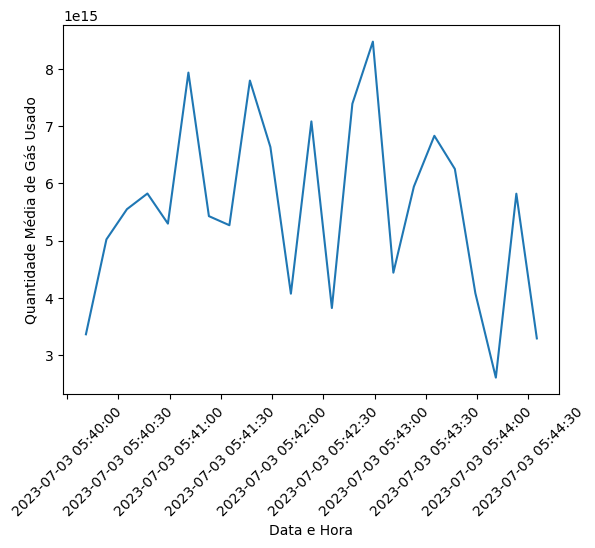

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyspark.sql.functions import col, to_timestamp, expr
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Converter a coluna 'Timestamp_Transacao' para o formato 'timestamp'
combined_transaction_df = combined_transaction_df.withColumn('Timestamp_Transacao', to_timestamp(col('Timestamp_Transacao')))

# Criar a coluna Gas_Utilizado, no qual Gas_Utilizado é o preço do gás vezes o limite
combined_transaction_df = combined_transaction_df.withColumn("Gas_Usado_Maximo", expr("Taxa_Gas * Limite_Gas"))

# Calcular a média de 'Gás_Usado' agrupada por data e hora
grouped_df = combined_transaction_df.groupBy('Timestamp_Transacao').mean('Gas_Usado_Maximo')

# Ordenar os valores pela coluna 'Timestamp_Transacao'
ordered_df = grouped_df.orderBy('Timestamp_Transacao')

# Obter os valores das colunas 'Timestamp_Transacao' e 'avg(Gás_Usado)' em listas
timestamps = ordered_df.select('Timestamp_Transacao').rdd.flatMap(lambda x: x).collect()
avg_gas_used = ordered_df.select('avg(Gas_Usado_Maximo)').rdd.flatMap(lambda x: x).collect()

# Plotar o gráfico
fig, ax = plt.subplots()
ax.plot(timestamps, avg_gas_used)

# Formatar o eixo x para exibir a data/hora
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation=45)

plt.xlabel('Data e Hora')
plt.ylabel('Quantidade Média de Gás Usado')

plt.show()